In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from ase.io import read, write
from ase.units import Hartree, kcal, mol
kcalpmol = kcal/mol
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cats = ['small','large','bh','inter_nc','intra_nc']
GGAs = ['PBE','RPBE','OLYP','revPBE','PW91','B97-D3']
MGGAs = ['SCAN','TPSS','revTPSS','M06L','M11L','MN12L']
Hybrids = ['PBE0','B3LYP','M052X','HSE06','wB97X-V']
funcs =  GGAs + MGGAs + Hybrids

In [3]:
for ext in ['_rho','_rho_alt','_abs','_kl','_burke_pbe','_burke_blyp']:
    def get_ae(dir_, func, skip = []):
        if func =='B97-D3':
            func = 'B97'
        if func == 'HSE06':
            func = 'hse06'
        if func == 'wB97X-V':
            func = 'wb97xv'
        ae = np.load(dir_+ "/{}_errors{}.npy".format(func, ext))
        return ae

    atoms = read('../data/haunschild_g2/g2_97.traj',':')
    ref = np.array([a.get_potential_energy()/Hartree for a in atoms])
    systems_train = [2, 113, 25, 18, 114, 0, 20, 26, 108, 107] #Training
    # systems_train += [23, 84, 144, 21, 116, 106, 50, 15, 58] # Expanded training
    systems_val = [103, 14, 23, 5, 10, 79, 27, 105] #Validation
    skip = systems_train + systems_val  # 15 is outlier for SCAN
    filt = np.arange(len(ref))
    filt = np.delete(filt, skip)
    erho = {
            f: get_ae('../testing/density/', f) for f in funcs + ['MGGA_REACTION2']
           }

    erho = {key:val[filt] for key,val in erho.items() }

    df_de = pd.DataFrame([{key:np.mean(np.abs(val)) for key,val in erho.items()}]).rename({'MGGA_REACTION2':'xc-diff'}, axis=1).T*1000
    df_de.columns = ['de']
    df_de.to_csv('../testing/density/density_error{}.csv'.format(ext.replace('rho','').replace('_','')))

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


In [4]:
with open('../testing/diet_indices', 'r') as file:
    line = file.readline()
    diet_idx = {}
    diet_weight = {}
    while(line):
        subset, weight, *indices = line.replace(',','').split()
        try:
            diet_idx[subset] = [int(i)-1 for i in indices]
            weight = float(weight)
        except ValueError:
            print(subset, weight, indices)
            raise ValueError
        diet_weight[subset] = weight 
        line = file.readline()

In [5]:
score = 0
score_cat = {c: 0 for c in cats}
score_funcs = {f:0 for f in funcs}
score_funcs_cat = {f:{c:0 for c in cats} for f in funcs}
cat_count = {c:0 for c in cats}
w411 = {f:0 for f in funcs}
bh = {f:0 for f in funcs}
mb = {f:0 for f in funcs}
running_idx = 0
ours = np.load('../testing/xc_diff_diet_gmtkn55.npy') + np.load('../testing/xc_diff_diet_gmtkn55.d3.npy')
for subset in diet_idx:
    for c in cats:
        try:
            ref = np.load('../testing/{}/ref_{}.npy'.format(c, subset))
            pred = ours[running_idx:running_idx + len(diet_idx[subset])]
            running_idx += len(diet_idx[subset])
            for func in funcs:
                try:
                    err_func = pd.read_csv('../testing/scraped/{}_{}.csv'.format(subset, func)).iloc[:, -1]
                except KeyError:
                    err_func = pd.read_csv('../testing/scraped/{}_{}.csv'.format(subset, func)).iloc[:, -1]
                except FileNotFoundError as e:
                    print('scraped not found')
                score_funcs[func] += diet_weight[subset] * np.sum(np.abs(err_func.loc[diet_idx[subset]]))
                score_funcs_cat[func][c] += diet_weight[subset] * np.sum(np.abs(err_func.loc[diet_idx[subset]]))
                if subset == 'W4-11':
                    w411[func] = np.mean(np.abs(err_func))
                elif subset == 'BH76':
                    bh[func] = np.mean(np.abs(err_func))
                elif subset == 'MB16-43':
                    mb[func] = np.mean(np.abs(err_func))
            dev = (ref[diet_idx[subset]]-pred)
            score += diet_weight[subset] * np.sum(np.abs(dev))
            score_cat[c] += diet_weight[subset] * np.sum(np.abs(dev))
            cat_count[c] += len(dev)
            if subset == 'W4-11':
                    w411['xc-diff'] = ref
            elif subset == 'BH76':
                    bh['xc-diff'] = ref
            elif subset == 'MB16-43':
                    mb['xc-diff'] = ref

            break
        except FileNotFoundError as e:

            if c == cats[-1]:
                raise FileNotFoundError
            pass
    

In [6]:
if subset == 'W4-11':
        w411['xc-diff'] = np.mean(np.abs(w411['xc-diff'] - np.load('../testing/xc_diff_w411.d3.npy') - np.load('../testing/xc_diff_w411.npy') ))
elif subset == 'BH76':
        bh['xc-diff'] = np.mean(np.abs(bh['xc-diff'] - np.load('../testing/xc_diff_bh76.d3.npy') - np.load('../testing/xc_diff_bh76.npy')))
elif subset == 'MB16-43':
        mb['xc-diff'] = np.mean(np.abs(mb['xc-diff']- np.load('../testing/xc_diff_mb16-43.d3.npy')- np.load('../testing/xc_diff_mb16-43.npy')))

In [7]:
by_cat = pd.DataFrame(score_funcs_cat)
by_cat['xc-diff'] = pd.DataFrame([score_cat]).T
by_cat['weight'] = pd.DataFrame([cat_count]).T
by_cat = by_cat.div(by_cat['weight'].astype(float), axis=0)

In [8]:
by_cat

,PBE,RPBE,OLYP,revPBE,PW91,B97-D3,SCAN,TPSS,revTPSS,M06L,M11L,MN12L,PBE0,B3LYP,M052X,HSE06,wB97X-V,xc-diff,weight
small,6.250223,6.143200,5.694722,5.218832,6.311208,5.232669,5.171175,5.750551,6.309324,4.729782,5.861732,5.926865,4.194322,3.759986,3.025874,3.789423,3.245288,4.296765,1.0
large,20.418006,15.747537,14.777775,17.903187,22.296650,23.497087,15.069919,20.364687,16.708675,25.391162,16.540450,20.383975,12.614169,17.603500,8.238975,13.814512,9.810494,15.071936,1.0
bh,18.019191,17.129100,16.157173,15.369600,17.635423,13.039782,12.671300,14.669036,14.066018,6.640536,5.528986,5.409945,8.590277,7.060023,4.802814,8.008986,4.227818,10.712422,1.0
inter_nc,8.605353,13.049171,6.196179,5.435882,9.973082,4.851782,6.173818,5.987406,5.182026,6.944632,11.349897,10.336759,5.936256,4.540076,4.778047,6.621138,2.745141,6.625399,1.0
intra_nc,8.868817,6.981197,6.615038,6.830283,10.283279,7.155652,7.348003,7.671041,6.734269,9.507348,12.337152,20.728034,5.770852,6.743762,4.670972,6.376441,3.781800,6.389050,1.0


In [9]:
wm = pd.DataFrame([score_funcs])
wm['xc-diff'] = score
wm = wm.T/150
wm.columns = ['WTMAD-2']
wm['XC-rung'] = ['2-GGA']*len(GGAs) + ['1-meta-GGA']*len(MGGAs) + ['0-hybrid'] * len(Hybrids) + ['1-meta-GGA']
# wm['XC-rung'] = ['1-GGA']*len(GGAs) + ['1-meta-GGA']*len(MGGAs) + ['0-hybrid'] * len(Hybrids) + ['2-meta-GGA']

In [10]:
# de = pd.read_csv('../testing/density_error_alt.csv',index_col=0)

# de.columns = ['Density error']

# by_cat = by_cat.append(wm)

# to_overleaf = by_cat.T.join(de)

# # print(to_overleaf.drop(['PBE','revPBE','TPSS0','B3LYP','PBE0','weight','tHCTH']).sort_values('WTMAD-2',ascending=False).round(2).to_latex())

# by_cat.rename({'bh':'barrier h.','inter_nc':'intermol. NC','intra_nc':'intramol. NC'},axis=0).drop(GGAs).sort_values('WTMAD-2',ascending=False).iloc[:-4].tail(6).T.drop('WTMAD-2').plot(kind='bar')

# xticks(rotation=20);
# tick_params(direction='in',axis='y')
# legend(loc='upper left')
# ylabel('WTMAD-2 (kcal/mol)')
# # savefig('results_gmtkn55/wtmad-cat-diet.pdf',bbox_inches='tight')

In [11]:
pareto = pd.read_csv('../testing/density/density_erroralt.csv',index_col=0).join(wm).dropna()
pareto = pd.read_csv('../testing/density/density_errorabs.csv',index_col=0).rename({'de':'de_abs'},axis=1).join(pareto).dropna()
pareto = pd.read_csv('../testing/density/density_error.csv',index_col=0).rename({'de':'de_weird'},axis=1).join(pareto).dropna()
pareto = pd.read_csv('../testing/density/density_errorkl.csv',index_col=0).rename({'de':'de_kl'},axis=1).join(pareto).dropna()
pareto = (pd.read_csv('../testing/density/density_errorburkepbe.csv',index_col=0)/1000*Hartree/kcalpmol).rename({'de':'de_burke'},axis=1).join(pareto).dropna()

pareto = pareto.sort_values(['XC-rung','WTMAD-2'], ascending = False)
pareto['XC-rung'] = pareto['XC-rung'].apply(lambda x: x[2:])
pareto = pareto.rename({'B97-D3':'B97'})

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np

0.8738694491795203


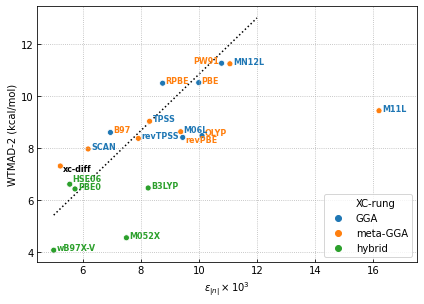

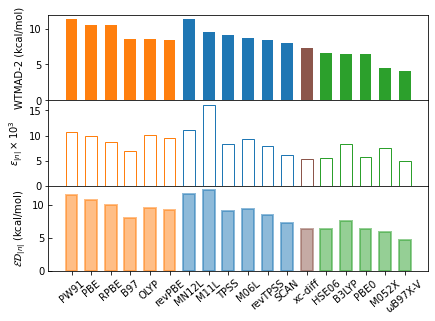

In [12]:
density_error = 'de_abs'
pareto['Name'] = pareto.index
pareto = pareto.rename({'wB97X-V':'ωB97X-V'})
for_fit = [ 'PBE0', 'SCAN', 'revTPSS', 'TPSS', 'PBE','PW91']
from sklearn.linear_model import LinearRegression as LR
lr = LR(fit_intercept=False)
pareto_fit = pareto.loc[for_fit,[density_error,'WTMAD-2']]
lr.fit(pareto_fit[[density_error]], pareto_fit['WTMAD-2'])



print(lr.score(pareto_fit[[density_error]],pareto_fit['WTMAD-2']))

figsize(6.8,4.7)
y = 'WTMAD-2'
# y = 'W4-11'
sns.scatterplot(x=pareto[density_error],y=pareto[y],hue=pareto['XC-rung'])
def label_point(x, y, val,rung, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val, 'rung':rung}, axis=1)
    for i, point in a.iterrows():
        color='C{}'.format({'GGA':1, 'meta-GGA':0,'hybrid':2}[point['rung']])
        x_offset = 0.1
        y_offset = 0 
        if point['val'] == 'xc-diff':
            color = 'black'
            y_offset = -.2
        elif str(point['val'])=='SCAN':
            y_offset = -.0
        elif str(point['val'])=='revTPSS':
            y_offset = -.0
        elif str(point['val'])=='B97-D3':
            y_offset = 0
#             x_offset = -0.015
        elif str(point['val'])=='revPBE':
            y_offset = -0.2
#             x_offset = -0.015
        elif str(point['val'])=='HSE06':
            y_offset = 0.1
#             x_offset = -0.015
        elif str(point['val'])=='PW91':
#             y_offset = -0.2
            x_offset = -0.98
        else:
            y_offset = 0
        ax.text(point['x']+x_offset, point['y']+y_offset, str(point['val']),
                fontdict= {'size':8,'weight':'heavy','color':color})

demin = pareto[density_error].min()
demax = pareto[density_error].max()
demax = 12

label_point(pareto[density_error], pareto[y], pareto['Name'],pareto['XC-rung'], plt.gca()) 
plot(np.linspace(demin,demax,100), lr.predict(np.linspace(demin,demax,100).reshape(-1,1)), zorder=-1, color='black',ls=':')
xlabel('$\epsilon_{|n|} \\times10^3$')
ylabel('WTMAD-2 (kcal/mol)')
grid(ls=':')
xlim(None,17.5)
tick_params(direction='in')
legend(loc='lower right')
# savefig('results_gmtkn55/pareto-1.pdf',bbox_inches='tight')
# savefig('results_gmtkn55/pareto.pdf',bbox_inches='tight')

pareto['de_E'] = lr.predict(pareto[[density_error]])

pareto['geometric'] = (1/2*(pareto['de_E']**2 + pareto['WTMAD-2']**2))**(1/2)
pareto['mean'] = 1/2*(pareto['de_E'] + pareto['WTMAD-2'])
pareto['harmonic'] = (1/2*(1/pareto['de_E'] + 1/pareto['WTMAD-2']))**(-1)

figsize(6.8,4.7)
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
ax1 = axs[0]
ax1.bar(pareto.index, pareto['WTMAD-2'], width=0.6,
    color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax1.set_ylabel('WTMAD-2 (kcal/mol)')
plt.setp(ax1.get_xticklabels(), visible = False)

ax2 = axs[1]
ax2.bar(pareto.index, pareto[density_error]*1, width=0.6, fill = False,
    edgecolor=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
# wm.sort_values(['rung','WTMAD-2'], ascending = False).iloc[:,0].plot(kind='bar',color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax2.set_ylabel('$\epsilon_{|n|} \\times10^3$')

ax3 = axs[2]

ax3.bar(pareto.index, pareto['harmonic'], width=0.6, fill = True, lw=2, alpha=0.5,
    edgecolor=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids),
    color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
# wm.sort_values(['rung','WTMAD-2'], ascending = False).iloc[:,0].plot(kind='bar',color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax3.set_ylabel('$ \mathcal{E} \mathcal{D}_{|n|}$ (kcal/mol)')
xticks(rotation=40);
tick_params(direction='in',axis='y');
# legend([])

# savefig('results_gmtkn55/wtmad-3.pdf',bbox_inches='tight')

In [13]:
pareto_save = pareto.loc[:,[density_error,'harmonic']].rename({'harmonic':'harmonic_abs'}, axis =1)
pareto_save[density_error] /= pareto_save[density_error].mean()/10

In [14]:
w411_ = pd.DataFrame([w411]).T.rename({'B97-D3':'B97'})
w411_.columns = ['W4-11']
bh_ = pd.DataFrame([bh]).T.rename({'B97-D3':'B97'})
bh_.columns = ['BH76']
mb_ = pd.DataFrame([mb]).T.rename({'B97-D3':'B97'})
mb_.columns = ['MB16-43']

pareto

pareto.join(w411_).join(bh_).join(mb_).loc[['B97','OLYP','revPBE','revTPSS','SCAN','xc-diff','PBE0'],
                                           ['W4-11','BH76','MB16-43','WTMAD-2',density_error, 'harmonic']]


,W4-11,BH76,MB16-43,WTMAD-2,de_abs,harmonic
B97,4.732238,7.297215,36.096279,8.611359,6.956697,8.044176
OLYP,9.890699,8.453291,29.041395,8.489665,10.107783,9.570085
revPBE,7.556364,8.33443,27.111395,8.421354,9.443270,9.243969
revTPSS,5.693497,8.89,36.746047,8.382872,7.916461,8.484346
SCAN,4.064336,7.776582,17.766744,7.975178,6.189111,7.290662
xc-diff,"[109.493, 213.169, 73.57, 324.945, 281.2870000...","[17.7, 82.6, 42.1, 42.1, 17.8, 17.8, 30.5, 56....","[869.5971, 737.7865, 518.6576, 356.8481, 147.6...",7.319412,5.232601,6.394221
PBE0,3.692308,4.995696,15.855581,6.436813,5.737568,6.328875


0.840730282311792


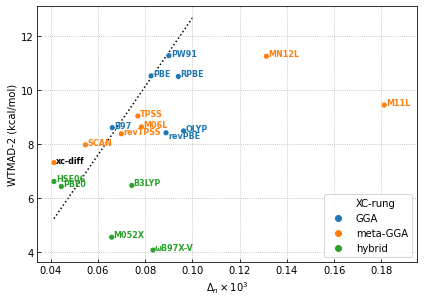

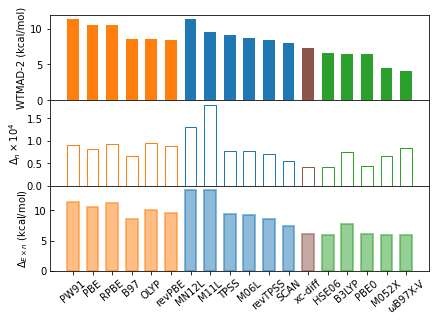

In [15]:
density_error = 'de'
pareto['Name'] = pareto.index

for_fit = [ 'PBE0', 'SCAN', 'revTPSS', 'TPSS', 'PBE','PW91']
from sklearn.linear_model import LinearRegression as LR
lr = LR(fit_intercept=False)
pareto_fit = pareto.loc[for_fit,[density_error,'WTMAD-2']]
lr.fit(pareto_fit[[density_error]], pareto_fit['WTMAD-2'])



print(lr.score(pareto_fit[[density_error]],pareto_fit['WTMAD-2']))

figsize(6.8,4.7)
y = 'WTMAD-2'
# y = 'W4-11'
sns.scatterplot(x=pareto[density_error],y=pareto[y],hue=pareto['XC-rung'])
def label_point(x, y, val,rung, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val, 'rung':rung}, axis=1)
    for i, point in a.iterrows():
        color='C{}'.format({'GGA':0, 'meta-GGA':1,'hybrid':2}[point['rung']])
        x_offset = 0.0008
        if point['val'] == 'xc-diff':
            color = 'black'
        if str(point['val'])=='SCAN':
            y_offset = -.0
        elif str(point['val'])=='revTPSS':
            y_offset = -.0
        elif str(point['val'])=='B97-D3':
            y_offset = 0
            x_offset = -0.015
        elif str(point['val'])=='revPBE':
            y_offset = -0.2
#             x_offset = -0.015
        else:
            y_offset = 0
        ax.text(point['x']+x_offset, point['y']+y_offset, str(point['val']),
                fontdict= {'size':8,'weight':'heavy','color':color})

demin = pareto[density_error].min()
demax = pareto[density_error].max()
demax = 0.10
label_point(pareto[density_error], pareto[y], pareto['Name'],pareto['XC-rung'], plt.gca()) 
plot(np.linspace(demin,demax,100), lr.predict(np.linspace(demin,demax,100).reshape(-1,1)), zorder=-1, color='black',ls=':')
xlabel('$\Delta_n \\times10^3$')
ylabel('WTMAD-2 (kcal/mol)')
grid(ls=':')
xlim(None,0.195)
tick_params(direction='in')
legend(loc='lower right')
# savefig('results_gmtkn55/pareto-1.pdf',bbox_inches='tight')
# savefig('results_gmtkn55/pareto-diet.pdf',bbox_inches='tight')

pareto['de_E'] = lr.predict(pareto[[density_error]])

pareto['geometric'] = (1/2*(pareto['de_E']**2 + pareto['WTMAD-2']**2))**(1/2)
pareto['mean'] = 1/2*(pareto['de_E'] + pareto['WTMAD-2'])
pareto['harmonic'] = (1/2*(1/pareto['de_E'] + 1/pareto['WTMAD-2']))**(-1)

figsize(6.8,4.7)
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
ax1 = axs[0]
ax1.bar(pareto.index, pareto['WTMAD-2'], width=0.6,
    color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax1.set_ylabel('WTMAD-2 (kcal/mol)')
plt.setp(ax1.get_xticklabels(), visible = False)

ax2 = axs[1]
ax2.bar(pareto.index, pareto[density_error]*10, width=0.6, fill = False,
    edgecolor=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
# wm.sort_values(['rung','WTMAD-2'], ascending = False).iloc[:,0].plot(kind='bar',color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax2.set_ylabel('$\Delta_n \\times10^4$')

ax3 = axs[2]

ax3.bar(pareto.index, pareto['harmonic'], width=0.6, fill = True, lw=2, alpha=0.5,
    edgecolor=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids),
    color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
# wm.sort_values(['rung','WTMAD-2'], ascending = False).iloc[:,0].plot(kind='bar',color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax3.set_ylabel('$\Delta_{E \\times n}$ (kcal/mol)')
xticks(rotation=40);
tick_params(direction='in',axis='y');
# legend([])

# savefig('results_gmtkn55/wtmad-3.pdf',bbox_inches='tight')

In [16]:
pareto_save = pareto_save.join(pareto.loc[:,[density_error,'harmonic']].rename({'harmonic':'harmonic'}, axis =1))
pareto_save[density_error] /= pareto_save[density_error].mean()/10

In [17]:
lr.coef_

array([126.75838473])

In [18]:
w411_ = pd.DataFrame([w411]).T.rename({'B97-D3':'B97'})
w411_.columns = ['W4-11']
bh_ = pd.DataFrame([bh]).T.rename({'B97-D3':'B97'})
bh_.columns = ['BH76']
mb_ = pd.DataFrame([mb]).T.rename({'B97-D3':'B97'})
mb_.columns = ['MB16-43']

# pareto

# print(pareto.join(w411_).join(bh_).join(mb_).loc[['RPBE','B97','OLYP','revPBE','M06L','revTPSS','SCAN','xc-diff','PBE0','B3LYP','M052X','wB97X-V'],
#                                            ['W4-11','BH76','MB16-43','WTMAD-2',density_error, 'harmonic']].round(1).to_latex())



In [19]:
print(pareto.join(w411_).join(bh_).join(mb_).loc[:,
                                           ['W4-11','BH76','MB16-43','WTMAD-2',density_error, 'harmonic']].round(1).to_latex())


\begin{tabular}{llllrrr}
\toprule
{} &                                              W4-11 &                                               BH76 &                                            MB16-43 &  WTMAD-2 &   de &  harmonic \\
\midrule
PW91    &                                          15.609161 &                                           9.886962 &                                           20.30093 &     11.3 &  0.1 &      11.3 \\
PBE     &                                          15.694056 &                                            9.63962 &                                          24.256977 &     10.5 &  0.1 &      10.5 \\
RPBE    &                                           8.296294 &                                           8.992911 &                                          50.764884 &     10.5 &  0.1 &      11.2 \\
B97     &                                           4.732238 &                                           7.297215 &                                          36.09

0.9840920379542696


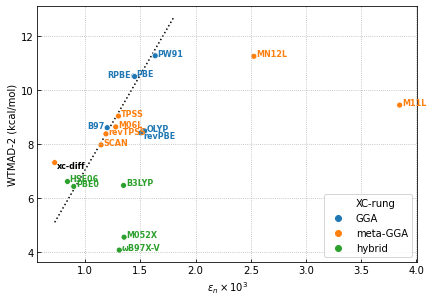

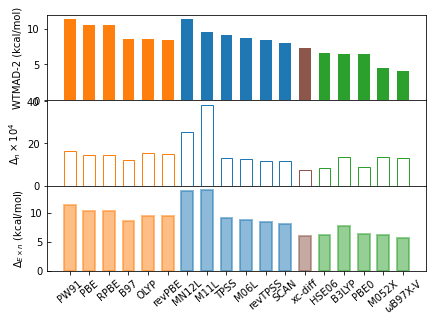

In [20]:
density_error = 'de_weird'
pareto['Name'] = pareto.index

for_fit = [ 'PBE0', 'SCAN', 'revTPSS', 'TPSS', 'PBE','PW91']
from sklearn.linear_model import LinearRegression as LR
lr = LR(fit_intercept=False)
pareto_fit = pareto.loc[for_fit,[density_error,'WTMAD-2']]
lr.fit(pareto_fit[[density_error]], pareto_fit['WTMAD-2'])



print(lr.score(pareto_fit[[density_error]],pareto_fit['WTMAD-2']))

figsize(6.8,4.7)
y = 'WTMAD-2'
# y = 'W4-11'
sns.scatterplot(x=pareto[density_error],y=pareto[y],hue=pareto['XC-rung'])
def label_point(x, y, val,rung, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val, 'rung':rung}, axis=1)
    for i, point in a.iterrows():
        color='C{}'.format({'GGA':0, 'meta-GGA':1,'hybrid':2}[point['rung']])
        x_offset = 0.02
        y_offset = 0 
        if point['val'] == 'xc-diff':
            color = 'black'
            y_offset = -.2
        elif str(point['val'])=='SCAN':
            y_offset = -.0
        elif str(point['val'])=='revTPSS':
            y_offset = -.0
        elif str(point['val'])=='B97':
            y_offset = 0
            x_offset = -0.18
        elif str(point['val'])=='revPBE':
            y_offset = -0.2
#             x_offset = -0.015
        elif str(point['val'])=='RPBE':
#             y_offset = -0.2
            x_offset = -0.25
        elif str(point['val'])=='PW91':
#             y_offset = -0.2
#             x_offset = -0.098
              pass
        else:
            y_offset = 0
        ax.text(point['x']+x_offset, point['y']+y_offset, str(point['val']),
                fontdict= {'size':8,'weight':'heavy','color':color})

demin = pareto[density_error].min()
demax = pareto[density_error].max()
demax = 1.8
label_point(pareto[density_error], pareto[y], pareto['Name'],pareto['XC-rung'], plt.gca()) 
plot(np.linspace(demin,demax,100), lr.predict(np.linspace(demin,demax,100).reshape(-1,1)), zorder=-1, color='black',ls=':')
xlabel('$\epsilon_n \\times10^3$')
ylabel('WTMAD-2 (kcal/mol)')
grid(ls=':')
# xlim(None,17.5)
tick_params(direction='in')
legend(loc='lower right')
# savefig('results_gmtkn55/pareto-1.pdf',bbox_inches='tight')
# savefig('results_gmtkn55/pareto-diet.pdf',bbox_inches='tight')

pareto['de_E'] = lr.predict(pareto[[density_error]])

pareto['geometric'] = (1/2*(pareto['de_E']**2 + pareto['WTMAD-2']**2))**(1/2)
pareto['mean'] = 1/2*(pareto['de_E'] + pareto['WTMAD-2'])
pareto['harmonic'] = (1/2*(1/pareto['de_E'] + 1/pareto['WTMAD-2']))**(-1)

figsize(6.8,4.7)
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
ax1 = axs[0]
ax1.bar(pareto.index, pareto['WTMAD-2'], width=0.6,
    color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax1.set_ylabel('WTMAD-2 (kcal/mol)')
plt.setp(ax1.get_xticklabels(), visible = False)

ax2 = axs[1]
ax2.bar(pareto.index, pareto[density_error]*10, width=0.6, fill = False,
    edgecolor=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
# wm.sort_values(['rung','WTMAD-2'], ascending = False).iloc[:,0].plot(kind='bar',color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax2.set_ylabel('$\Delta_n \\times10^4$')

ax3 = axs[2]

ax3.bar(pareto.index, pareto['harmonic'], width=0.6, fill = True, lw=2, alpha=0.5,
    edgecolor=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids),
    color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
# wm.sort_values(['rung','WTMAD-2'], ascending = False).iloc[:,0].plot(kind='bar',color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax3.set_ylabel('$\Delta_{E \\times n}$ (kcal/mol)')
xticks(rotation=40);
tick_params(direction='in',axis='y');
# legend([])

# savefig('results_gmtkn55/wtmad-3.pdf',bbox_inches='tight')

In [21]:
pareto_save = pareto_save.join(pareto.loc[:,[density_error,'harmonic']].rename({'harmonic':'harmonic_weird'}, axis =1))
pareto_save[density_error] /= pareto_save[density_error].mean()/10

0.8888285351623552


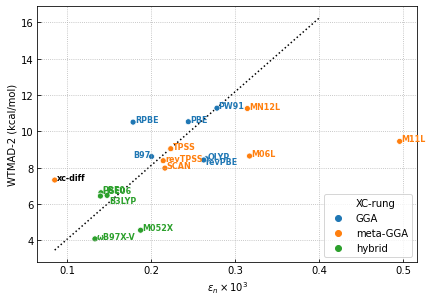

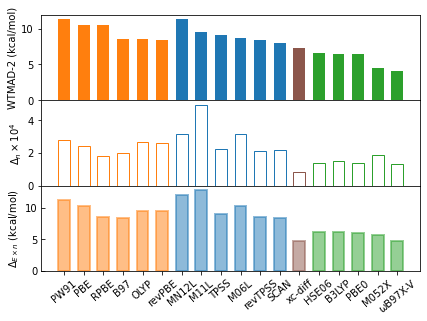

In [22]:
density_error = 'de_kl'
pareto['Name'] = pareto.index

for_fit = [ 'PBE0', 'SCAN', 'revTPSS', 'TPSS', 'PBE','PW91']
from sklearn.linear_model import LinearRegression as LR
lr = LR(fit_intercept=False)
pareto_fit = pareto.loc[for_fit,[density_error,'WTMAD-2']]
lr.fit(pareto_fit[[density_error]], pareto_fit['WTMAD-2'])



print(lr.score(pareto_fit[[density_error]],pareto_fit['WTMAD-2']))

figsize(6.8,4.7)
y = 'WTMAD-2'
# y = 'W4-11'
sns.scatterplot(x=pareto[density_error],y=pareto[y],hue=pareto['XC-rung'])
def label_point(x, y, val,rung, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val, 'rung':rung}, axis=1)
    for i, point in a.iterrows():
        color='C{}'.format({'GGA':0, 'meta-GGA':1,'hybrid':2}[point['rung']])
        x_offset = 0.002
        y_offset = 0 
        if point['val'] == 'xc-diff':
            color = 'black'
            y_offset = -.02
        elif str(point['val'])=='SCAN':
            y_offset = -.0
        elif str(point['val'])=='revTPSS':
            y_offset = -.0
        elif str(point['val'])=='B97':
            y_offset = 0
            x_offset = -0.022
        elif str(point['val'])=='revPBE':
            y_offset = -0.2
#             x_offset = -0.015
        elif str(point['val'])=='RPBE':
#             y_offset = -0.2
#             x_offset = -0.025
              pass
        elif str(point['val'])=='PW91':
#             y_offset = -0.2
#             x_offset = -0.098
              pass
        elif str(point['val'])=='B3LYP':
            y_offset = -0.4
#             x_offset = -0.098
        elif str(point['val'])=='PBE0':
            y_offset = 0.2
#             x_offset = -0.098      
        else:
            y_offset = 0
        ax.text(point['x']+x_offset, point['y']+y_offset, str(point['val']),
                fontdict= {'size':8,'weight':'heavy','color':color})

demin = pareto[density_error].min()
demax = pareto[density_error].max()
demax = 0.4
label_point(pareto[density_error], pareto[y], pareto['Name'],pareto['XC-rung'], plt.gca()) 
plot(np.linspace(demin,demax,100), lr.predict(np.linspace(demin,demax,100).reshape(-1,1)), zorder=-1, color='black',ls=':')
xlabel('$\epsilon_n \\times10^3$')
ylabel('WTMAD-2 (kcal/mol)')
grid(ls=':')
# xlim(None,17.5)
tick_params(direction='in')
legend(loc='lower right')
# savefig('results_gmtkn55/pareto-1.pdf',bbox_inches='tight')
# savefig('results_gmtkn55/pareto-diet.pdf',bbox_inches='tight')

pareto['de_E'] = lr.predict(pareto[[density_error]])

pareto['geometric'] = (1/2*(pareto['de_E']**2 + pareto['WTMAD-2']**2))**(1/2)
pareto['mean'] = 1/2*(pareto['de_E'] + pareto['WTMAD-2'])
pareto['harmonic'] = (1/2*(1/pareto['de_E'] + 1/pareto['WTMAD-2']))**(-1)

figsize(6.8,4.7)
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
ax1 = axs[0]
ax1.bar(pareto.index, pareto['WTMAD-2'], width=0.6,
    color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax1.set_ylabel('WTMAD-2 (kcal/mol)')
plt.setp(ax1.get_xticklabels(), visible = False)

ax2 = axs[1]
ax2.bar(pareto.index, pareto[density_error]*10, width=0.6, fill = False,
    edgecolor=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
# wm.sort_values(['rung','WTMAD-2'], ascending = False).iloc[:,0].plot(kind='bar',color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax2.set_ylabel('$\Delta_n \\times10^4$')

ax3 = axs[2]

ax3.bar(pareto.index, pareto['harmonic'], width=0.6, fill = True, lw=2, alpha=0.5,
    edgecolor=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids),
    color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
# wm.sort_values(['rung','WTMAD-2'], ascending = False).iloc[:,0].plot(kind='bar',color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax3.set_ylabel('$\Delta_{E \\times n}$ (kcal/mol)')
xticks(rotation=40);
tick_params(direction='in',axis='y');
# legend([])

# savefig('results_gmtkn55/wtmad-3.pdf',bbox_inches='tight')

In [23]:
pareto_save = pareto_save.join(pareto.loc[:,[density_error,'harmonic']].rename({'harmonic':'harmonic_kl'}, axis =1))
pareto_save[density_error] /= pareto_save[density_error].mean()/10

In [24]:
pareto_save = pareto_save.round(1)

In [25]:
pareto_save = pareto_save.loc[:,[c for c in  pareto_save.columns if 'de' in c] + [c for c in  pareto_save.columns if 'de' not in c]]

In [26]:
print(pareto_save.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  de\_abs &    de &  de\_weird &  de\_kl &  harmonic\_abs &  harmonic &  harmonic\_weird &  harmonic\_kl \\
\midrule
PW91    &    12.7 &  11.1 &      11.1 &   12.4 &          11.5 &      11.3 &            11.4 &         11.3 \\
PBE     &    11.8 &  10.2 &       9.8 &   10.9 &          10.7 &      10.5 &            10.3 &         10.2 \\
RPBE    &    10.3 &  11.6 &       9.8 &    7.9 &          10.0 &      11.2 &            10.4 &          8.6 \\
B97     &     8.2 &   8.1 &       8.1 &    8.9 &           8.0 &       8.5 &             8.5 &          8.4 \\
OLYP    &    11.9 &  11.9 &      10.4 &   11.8 &           9.6 &      10.0 &             9.5 &          9.5 \\
revPBE  &    11.2 &  10.9 &      10.2 &   11.7 &           9.2 &       9.6 &             9.4 &          9.4 \\
MN12L   &    13.1 &  16.2 &      17.2 &   14.0 &          11.6 &      13.4 &            13.8 &         12.0 \\
M11L    &    19.1 &  22.3 &      26.1 &   22.1 &          12.3 &  

-3.6282686591824342


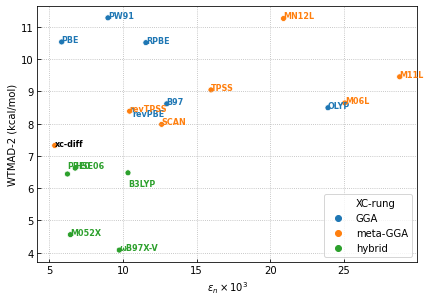

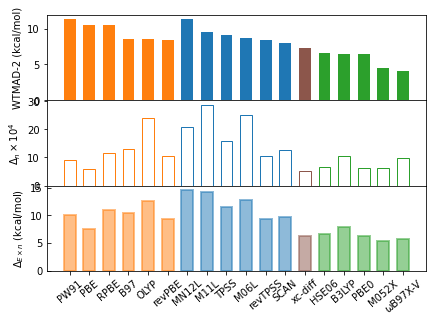

In [27]:
density_error = 'de_burke'
pareto['Name'] = pareto.index

for_fit = [ 'PBE0', 'SCAN', 'revTPSS', 'TPSS', 'PBE','PW91']
from sklearn.linear_model import LinearRegression as LR
lr = LR(fit_intercept=False)
pareto_fit = pareto.loc[for_fit,[density_error,'WTMAD-2']]
lr.fit(pareto_fit[[density_error]], pareto_fit['WTMAD-2'])



print(lr.score(pareto_fit[[density_error]],pareto_fit['WTMAD-2']))

figsize(6.8,4.7)
y = 'WTMAD-2'
# y = 'W4-11'
sns.scatterplot(x=pareto[density_error],y=pareto[y],hue=pareto['XC-rung'])
def label_point(x, y, val,rung, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val, 'rung':rung}, axis=1)
    for i, point in a.iterrows():
        color='C{}'.format({'GGA':0, 'meta-GGA':1,'hybrid':2}[point['rung']])
        x_offset = 0.002
        y_offset = 0 
        if point['val'] == 'xc-diff':
            color = 'black'
            y_offset = -.02
        elif str(point['val'])=='SCAN':
            y_offset = -.0
        elif str(point['val'])=='revTPSS':
            y_offset = -.0
        elif str(point['val'])=='B97':
            y_offset = 0
            x_offset = -0.022
        elif str(point['val'])=='revPBE':
            y_offset = -0.2
#             x_offset = -0.015
        elif str(point['val'])=='RPBE':
#             y_offset = -0.2
#             x_offset = -0.025
              pass
        elif str(point['val'])=='PW91':
#             y_offset = -0.2
#             x_offset = -0.098
              pass
        elif str(point['val'])=='B3LYP':
            y_offset = -0.4
#             x_offset = -0.098
        elif str(point['val'])=='PBE0':
            y_offset = 0.2
#             x_offset = -0.098      
        else:
            y_offset = 0
        ax.text(point['x']+x_offset, point['y']+y_offset, str(point['val']),
                fontdict= {'size':8,'weight':'heavy','color':color})

# demin = pareto[density_error].min()
# demax = pareto[density_error].max()
# demax = 0.4
label_point(pareto[density_error], pareto[y], pareto['Name'],pareto['XC-rung'], plt.gca()) 
# plot(np.linspace(demin,demax,100), lr.predict(np.linspace(demin,demax,100).reshape(-1,1)), zorder=-1, color='black',ls=':')
xlabel('$\epsilon_n \\times10^3$')
ylabel('WTMAD-2 (kcal/mol)')
grid(ls=':')
# xlim(None,17.5)
tick_params(direction='in')
legend(loc='lower right')
# savefig('results_gmtkn55/pareto-1.pdf',bbox_inches='tight')
# savefig('results_gmtkn55/pareto-diet.pdf',bbox_inches='tight')

pareto['de_E'] = pareto[density_error]

pareto['geometric'] = (1/2*(pareto['de_E']**2 + pareto['WTMAD-2']**2))**(1/2)
pareto['mean'] = 1/2*(pareto['de_E'] + pareto['WTMAD-2'])
pareto['harmonic'] = (1/2*(1/pareto['de_E'] + 1/pareto['WTMAD-2']))**(-1)

figsize(6.8,4.7)
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
ax1 = axs[0]
ax1.bar(pareto.index, pareto['WTMAD-2'], width=0.6,
    color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax1.set_ylabel('WTMAD-2 (kcal/mol)')
plt.setp(ax1.get_xticklabels(), visible = False)

ax2 = axs[1]
ax2.bar(pareto.index, pareto[density_error], width=0.6, fill = False,
    edgecolor=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
# wm.sort_values(['rung','WTMAD-2'], ascending = False).iloc[:,0].plot(kind='bar',color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax2.set_ylabel('$\Delta_n \\times10^4$')

ax3 = axs[2]

ax3.bar(pareto.index, pareto['harmonic'], width=0.6, fill = True, lw=2, alpha=0.5,
    edgecolor=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids),
    color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
# wm.sort_values(['rung','WTMAD-2'], ascending = False).iloc[:,0].plot(kind='bar',color=['C1']*len(GGAs) + ['C0'] *len(MGGAs) + ['C5'] + ['C2']*len(Hybrids))
ax3.set_ylabel('$\Delta_{E \\times n}$ (kcal/mol)')
xticks(rotation=40);
tick_params(direction='in',axis='y');
# legend([])

# savefig('results_gmtkn55/wtmad-3.pdf',bbox_inches='tight')

In [28]:
import urllib
funcs = ['wB97X-V']
for func in funcs:
    for system in diet_idx:
#     for system in ['YBDE18']:

        page = urllib.request.urlopen('http://www.thch.uni-bonn.de/tc.old/downloads/GMTKN/GMTKN55/results/{}/{}/result.html'.format(system, func))
        with open('temp_result','w') as tmpfile:
            tmpfile.write(page.read().decode())
        if system == 'YBDE18':
            try:
                errors = pd.read_html('temp_result', index_col = 0)[0]['Unnamed: 12']
            except KeyError:
                try:
                    errors = pd.read_html('temp_result', index_col = 0)[0]['Unnamed: 11']
                except KeyError:
                    errors = pd.read_html('temp_result', index_col = 0)[0].iloc[:,-1]
        else:
            try:
                errors = pd.read_html('temp_result', index_col = 0)[0]['D3(BJ)']
            except KeyError:
                try:
                    errors = pd.read_html('temp_result', index_col = 0)[0]['D3(0)']
                except KeyError:
                    errors = pd.read_html('temp_result', index_col = 0)[0].iloc[:,-1]
        errors.to_csv('../testing/scraped/{}_{}.csv'.format(system, func))